# Machine Learning Engineer Nanodegree
## Capstone Project
Simon Jackson
March 21st, 2017

---

In [4]:
import os
import numpy as np
import pandas as pd

# Pretty display for notebooks
%matplotlib inline

## Data Importing and preprocessing

Data was downloaded as .zip format...

Extract all data from zip files into the same directory

In [5]:
# Utility variables
data_directory = "data"

In [6]:
from scripts import extract_zips

# Extract all files from zip folders in data directory,
# into data directory
if False:
    extract_zips.extract_all(data_directory)
else:
    print "Extraction turned off. Check that files have been extracted."
    
print "\nFiles in the data directory:\n"
for f in os.listdir(data_directory):
    print "- " + f

Extraction turned off. Check that files have been extracted.

Files in the data directory:

- genome_scores.csv
- genome_tags.csv
- imdb-5000-movie-dataset.zip
- link.csv
- movie.csv
- movielens-20m-dataset.zip
- movie_metadata.csv
- rating.csv
- tag.csv


### IMDB data

In [8]:
from scripts import data_imdb

imdb = data_imdb.prep(data_directory)

data\movie_metadata.csv read with 5043 rows and 28 columns.


In [9]:
imdb.shape

(5043, 48)

In [10]:
# Column types
imdb.dtypes

color                           bool
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_1_facebook_likes       float64
gross                        float64
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
movie_imdb_link               object
num_user_for_reviews         float64
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
movie_facebook_likes           int64
english                         bool
action                         int64
adventure                      int64
animation                      int64
biography                      int64
comedy                         int64
c

In [11]:
# Examine few rows
imdb.head(n = 5)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,num_voted_users,cast_total_facebook_likes,...,mystery,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western
0,True,723.0,178.0,0.0,855.0,1000.0,760505847.0,Avatar,886204,4834,...,0,0,0,0,1,0,0,0,0,0
1,True,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Pirates of the Caribbean: At World's End,471220,48350,...,0,0,0,0,0,0,0,0,0,0
2,True,602.0,148.0,0.0,161.0,11000.0,200074175.0,Spectre,275868,11700,...,0,0,0,0,0,0,0,1,0,0
3,True,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,The Dark Knight Rises,1144337,106759,...,0,0,0,0,0,0,0,1,0,0
4,False,NaN,NaN,131.0,NaN,131.0,NaN,Star Wars: Episode VII - The Force Awakens ...,8,143,...,0,0,0,0,0,0,0,0,0,0


This information will be used for content-based filtering of movies.

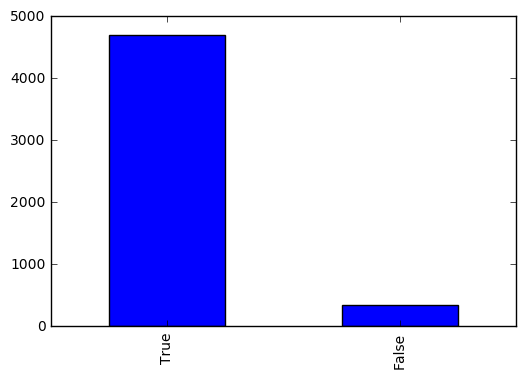

In [12]:
imdb['english'].value_counts().plot(kind="bar")
#imdb['content_rating']#.nunique

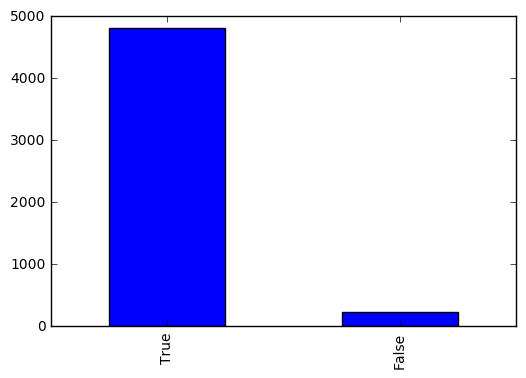

In [13]:
imdb['color'].value_counts().plot(kind="bar")

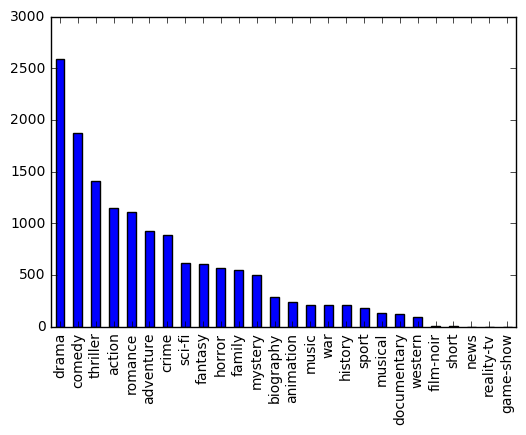

In [8]:
# Visualise counts of genres
genre_dummies = pd.melt(imdb.ix[:, 'action':'western'])
genre_dummies.variable[genre_dummies.value == 1].value_counts().plot(kind="bar")

In [9]:
# Separate title and IMDB link
#imdb_titles = imdb[['movie_title', 'movie_imdb_link']]

#imdb.drop(['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
#           'plot_keywords', 'movie_title', 'movie_imdb_link'], axis = 1, inplace = True)

#print 'Titles data has {} rows and {} columns'.format(*imdb_titles.shape) 
#print 'Movie data has {} rows and {} columns'.format(*imdb.shape)

#### Categorical variables

- `language`: convert to 1 = English, 0 = other
- `genres`: will need to be split into multiple variables indicating whether certain genres were tagged.
- `country`: 1 = USA, 0 = Other (possibly a separate one for UK?)
- `content_rating`: will need a number of categories (R, PG, PG-13, G, etc)

In [11]:
imdb.ix[imdb.language != 'English', 'language'] = 'Other'
imdb.language.value_counts()

English    4704
Other       339
Name: language, dtype: int64

In [14]:
# Obtain dummy coded versions of all genres
imdb.head(5)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,movie_title,num_voted_users,...,mystery,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western
0,Color,723.0,178.0,0.0,855.0,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,...,0,0,0,0,1,0,0,0,0,0
1,Color,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,471220,...,0,0,0,0,0,0,0,0,0,0
2,Color,602.0,148.0,0.0,161.0,11000.0,200074175.0,Action|Adventure|Thriller,Spectre,275868,...,0,0,0,0,0,0,0,1,0,0
3,Color,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,Action|Thriller,The Dark Knight Rises,1144337,...,0,0,0,0,0,0,0,1,0,0
4,NaN,NaN,NaN,131.0,NaN,131.0,NaN,Documentary,Star Wars: Episode VII - The Force Awakens ...,8,...,0,0,0,0,0,0,0,0,0,0


,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,movie_title,num_voted_users,...,mystery,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western
0,Color,723.0,178.0,0.0,855.0,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,...,0,0,0,0,1,0,0,0,0,0
1,Color,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,471220,...,0,0,0,0,0,0,0,0,0,0
2,Color,602.0,148.0,0.0,161.0,11000.0,200074175.0,Action|Adventure|Thriller,Spectre,275868,...,0,0,0,0,0,0,0,1,0,0
3,Color,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,Action|Thriller,The Dark Knight Rises,1144337,...,0,0,0,0,0,0,0,1,0,0
4,NaN,NaN,NaN,131.0,NaN,131.0,NaN,Documentary,Star Wars: Episode VII - The Force Awakens ...,8,...,0,0,0,0,0,0,0,0,0,0


['color',
 'num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'gross',
 'genres',
 'movie_title',
 'num_voted_users',
 'cast_total_facebook_likes',
 'facenumber_in_poster',
 'movie_imdb_link',
 'num_user_for_reviews',
 'language',
 'country',
 'content_rating',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'imdb_score',
 'aspect_ratio',
 'movie_facebook_likes',
 'action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'thriller',
 'war',
 'western',
 'action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci

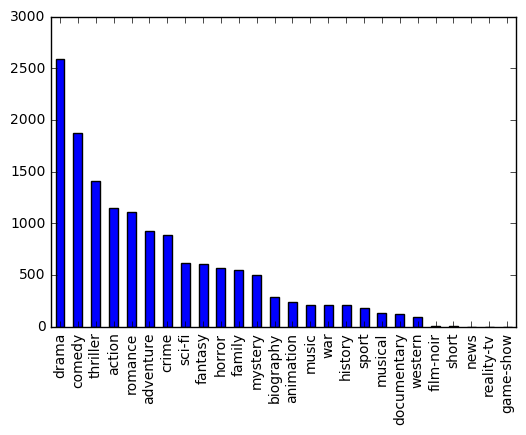

In [15]:
# Show counts of different genres
x = pd.melt(dummy_genres)
x.variable[x.value == 1].value_counts().plot(kind="bar")
list(imdb)

In [17]:
list(dummy_genres)

['action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'thriller',
 'war',
 'western']